<a href="https://colab.research.google.com/github/dltdscientist/MBA_em_Data_Science_Projeto_Big_Data/blob/main/Projeto_de_Big_Data_MBA_Daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Projeto de Big Data - MBA em Data Science - FAMESP/FLAI**

###**Descreva o problema ou a dor de negócio que você quer explorar na sua análise.**
### Este projeto tem como objetivo analisar a quantidade de mortes com relação a algumas variáveis, que podem auxiliar nas tomadas de decisões quanto a políticas públicas que poderão ser propostas para diminuir a mortalidade da população brasileira.
### **Quais dados você tem disponível para a análise?**
###Foram utilizados dados abertos do Sistema de Informação sobre Mortalidade - SIM, disponibilizados pelo OPENDATASUS. Neste trabalho foi utilizada a planilha de Mortalidade Geral 2023 - Prévia, por conter menor quantidade de dados. Entretanto, as análises podem ser aplicadas sobre os dados de qualquer dos anos publicados.

### **Que hipóteses você pretende validar?**
###   Foram levantadas as seguintes questões:
###1. Qual a distribuição de mortes por sexo?
###2. Qual a distribuição de mortes por estado civil?
###3. Qual a distribuição de mortes por raça/cor?
###4. Qual a distribuição de mortes por escolaridade?
###5. Qual a distribuição de mortes por faixa etária?
###6. Qual a distribuição de mortes por circunstância de morte não natural?
###7. Qual a distribuição das circunstâncias de morte não natural por sexo?
###8. Quais grupos de ocupação tiveram mais mortes por acidentes de trabalho?
###9. Qual a distribuição de mortes por causa da morte?
###10. Quais são as faixas etárias com maior número de suicídios?
###11. Quais são as causas de morte mais frequentes por UF?
###12. Quais são as circunstâncias de morte não natural mais frequentes por UF?


###**O que você pode concluir de cada uma das análises?**
### A conclusão de cada uma dessas análises foi incluida logo abaixo da execução do respectivo código.

**Inicialização**

In [1]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

In [2]:
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [3]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-3.5.0-bin-hadoop3')

In [4]:
# download do http para arquivo local
!wget --quiet --show-progress https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/DO23OPEN.csv

DO23OPEN.csv        100%[===================>] 169.01M  20.0MB/s    in 10s     


In [5]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
spark = SparkSession.builder.master('local[*]').getOrCreate()
sc = spark.sparkContext

from pyspark import pandas as ps

# Ativar o suporte a Arrow para melhorar o desempenho
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

/content/spark-3.5.0-bin-hadoop3/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


**Lendo a fonte de dados**

In [6]:
# mort = spark.read.csv("./DO23OPEN.csv", inferSchema=True, header=True)
mort = spark.read.options(delimiter=";", header=True).csv("./DO23OPEN.csv")
mort.show()

+--------+------+--------+--------+---------+-------+----------+--------+-----+----+-------+------+----+-------+----------+------+---------+-------+--------+----------+--------+------+----------+----------+-------+----------+----------+--------+----------+--------+-----+----------+----+----------+---------+----------+---------+-----+--------+---------+----------+------+------+------+----------+--------+------+----------+----------+---------+--------+-----+----------+----------+----------+---------+----------+----------+----------+---------+--------+---------+--------------------+----------+-------+--------+----------+----------+----------+--------+-------+----------+--------+----------+--------+------+----------+----------+--------+----------+---------+--------+----------+-----+---------+------+
|contador|ORIGEM|TIPOBITO| DTOBITO|HORAOBITO|NATURAL|CODMUNNATU|  DTNASC|IDADE|SEXO|RACACOR|ESTCIV| ESC|ESC2010|SERIESCFAL|  OCUP|CODMUNRES|LOCOCOR|CODESTAB|CODMUNOCOR|IDADEMAE|ESCMAE|ESCMAE201

**Selecionando somente as variáveis que vamos utilizar**

In [7]:
mort = mort['ACIDTRAB','CAUSABAS','CIRCOBITO','CODMUNOCOR','ESC2010','ESTCIV','IDADE','OCUP','RACACOR','SEXO']
mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+
|    NULL|     R99|     NULL|    130260|      3|     1|  479|999993|      1|   1|
|    NULL|    B909|     NULL|    130260|      2|     1|  469|511215|      4|   2|
|    NULL|     I10|     NULL|    130260|      3|     4|  468|371310|   NULL|   1|
|       2|    V299|        1|    140010|      5|     1|  432|517310|      4|   1|
|    NULL|    P038|     NULL|    130260|   NULL|  NULL| NULL|  NULL|   NULL|   1|
|    NULL|    G309|     NULL|    130260|      1|     3|  490|631105|      4|   1|
|    NULL|    I678|     NULL|    130260|      2|     2|  469|999992|      4|   2|
|    NULL|    I359|     NULL|    130260|      2|     2|  483|612005|      1|   1|
|    NULL|    N390|     NULL|    130260|      5|     1|  443|234520|      4|   1|
|    NULL|    B2

**Decodificando os dados**

In [8]:
# Acidente de Trabalho

# Substituindo nulos por 9
mort = mort.withColumn('ACIDTRAB', f.when(mort.ACIDTRAB.isNotNull(), mort.ACIDTRAB).otherwise(9))

acidtrab = {1:'Sim', 2:'Não', 9:'ignorado'}

acidtrab_df = spark.sparkContext.parallelize([(k,)+(v,) for k,v in acidtrab.items()]).toDF(['codigo','desc_acidtrab'])

mort = mort.join(acidtrab_df, on=[mort.ACIDTRAB == acidtrab_df.codigo])

mort = mort.drop('codigo')

mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+
|       1|    X684|        1|    210300|      0|     2|  455|612005|      2|   1|          Sim|
|       1|    V234|        1|    250750|   NULL|     1|  439|  NULL|      4|   1|          Sim|
|       1|    V239|        1|    292620|      9|     1|  418|848305|      4|   1|          Sim|
|       1|    V234|        1|    292620|      4|     2|  424|784105|      4|   1|          Sim|
|       1|    V274|        1|    311860|      3|     1|  426|519110|      1|   1|          Sim|
|       1|    V234|        1|    316900|      9|     1|  459|717010|      4|   1|          Sim|
|       1|    Y349|        1|    430676|      2|     2|  463|773120|      1|   1|          Sim|
|       1|    W878|        1|    510850|

In [9]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.desc_acidtrab).count()
dataframe_tmp.toPandas()

,desc_acidtrab,count
0,Sim,1217
1,Não,9899
2,ignorado,505905


In [10]:
# Circunstância do óbito

# Substituindo nulos por 9
mort = mort.withColumn('CIRCOBITO', f.when(mort.CIRCOBITO.isNotNull(), mort.CIRCOBITO).otherwise(9))

circobito = {1:'acidente', 2:'suicidio', 3:'homicidio', 4:'outros', 9:'ignorado'}

circobito_df = spark.sparkContext.parallelize([(k,)+(v,) for k,v in circobito.items()]).toDF(['codigo','desc_circobito'])

mort = mort.join(circobito_df, on=[mort.CIRCOBITO == circobito_df.codigo])

mort = mort.drop('codigo')

mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+
|       9|     R99|        9|    130260|      3|     1|  479|999993|      1|   1|     ignorado|      ignorado|
|       9|    B909|        9|    130260|      2|     1|  469|511215|      4|   2|     ignorado|      ignorado|
|       9|     I10|        9|    130260|      3|     4|  468|371310|   NULL|   1|     ignorado|      ignorado|
|       9|    P038|        9|    130260|   NULL|  NULL| NULL|  NULL|   NULL|   1|     ignorado|      ignorado|
|       9|    G309|        9|    130260|      1|     3|  490|631105|      4|   1|     ignorado|      ignorado|
|       9|    I678|        9|    130260|      2|     2|  469|999992|      4|   2|     ignorado|      ignorado|
|

In [11]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.desc_circobito).count()
dataframe_tmp.toPandas()

,desc_circobito,count
0,ignorado,478272
1,suicidio,4858
2,outros,1480
3,acidente,19494
4,homicidio,12917


In [12]:
# Escolaridade

# Substituindo nulos por 9
mort = mort.withColumn('ESC2010', f.when(mort.ESC2010.isNotNull(), mort.ESC2010).otherwise(9))

esc2010 = {0:'Sem escolaridade', 1:'Fundamental I', 2:'Fundamental II', 3:'Médio', 4:'Superior incompleto', 5:'Superior completo', 9:'Ignorado'}

esc2010_df = spark.sparkContext.parallelize([(k,)+(v,) for k,v in esc2010.items()]).toDF(['codigo','desc_esc2010'])

mort = mort.join(esc2010_df, on=[mort.ESC2010 == esc2010_df.codigo])

mort = mort.drop('codigo')

mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+----------------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|    desc_esc2010|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+----------------+
|       9|    C449|        9|    130320|      0|     3|  491|999993|      4|   2|     ignorado|      ignorado|Sem escolaridade|
|       9|    J961|        9|    130370|      0|     5|  492|999993|      5|   1|     ignorado|      ignorado|Sem escolaridade|
|       9|     R99|        9|    130420|      0|     5|  480|631210|      2|   1|     ignorado|      ignorado|Sem escolaridade|
|       9|    B500|        9|    140010|      0|     1|  434|622020|      5|   1|     ignorado|      ignorado|Sem escolaridade|
|       9|    I219|        9|    140010|      0|     1|  475|354705|      1|   2|     ignorado|      ign

In [13]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.desc_esc2010).count()
dataframe_tmp.toPandas()

,desc_esc2010,count
0,Fundamental II,78279
1,Superior incompleto,5080
2,Ignorado,96126
3,Médio,75187
4,Superior completo,27816
5,Fundamental I,158490
6,Sem escolaridade,76043


In [14]:
# Estado civil

# Substituindo nulos por 9
mort = mort.withColumn('ESTCIV', f.when(mort.ESTCIV.isNotNull(), mort.ESTCIV).otherwise(9))

estciv = {1:'Solteiro', 2:'Casado', 3:'Viúvo', 4:'Separado judicialmente/divorciado', 5:'União estável', 9:'Ignorado'}

estciv_df = spark.sparkContext.parallelize([(k,)+(v,) for k,v in estciv.items()]).toDF(['codigo','desc_estciv'])

mort = mort.join(estciv_df, on=[mort.ESTCIV == estciv_df.codigo])

mort = mort.drop('codigo')

mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+----------------+-----------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|    desc_esc2010|desc_estciv|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+----------------+-----------+
|       9|    B500|        9|    140010|      0|     1|  434|622020|      5|   1|     ignorado|      ignorado|Sem escolaridade|   Solteiro|
|       9|    I219|        9|    140010|      0|     1|  475|354705|      1|   2|     ignorado|      ignorado|Sem escolaridade|   Solteiro|
|       9|    K210|        9|    150120|      0|     1|  452|622020|      4|   1|     ignorado|      ignorado|Sem escolaridade|   Solteiro|
|       9|    I639|        9|    150140|      0|     1|  490|999992|      4|   2|     ignorado|      ignorado|Sem escolaridade|   Solteiro|
|       9|     I64| 

In [15]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.desc_estciv).count()
dataframe_tmp.toPandas()

,desc_estciv,count
0,Separado judicialmente/divorciado,38097
1,Ignorado,55099
2,Viúvo,119865
3,União estável,16500
4,Solteiro,132928
5,Casado,154532


In [16]:
# Raça/Cor

# Substituindo nulos por 9
mort = mort.withColumn('RACACOR', f.when(mort.RACACOR.isNotNull(), mort.RACACOR).otherwise(9))

racacor = {1:'Branca', 2:'Preta',3:'Amarela', 4:'Parda', 5:'Indígena', 9:'Ignorado'}

racacor_df = spark.sparkContext.parallelize([(k,)+(v,) for k,v in racacor.items()]).toDF(['codigo','desc_racacor'])

mort = mort.join(racacor_df, on=[mort.RACACOR == racacor_df.codigo])

mort = mort.drop('codigo')

mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+----------------+-----------+------------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|    desc_esc2010|desc_estciv|desc_racacor|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+----------------+-----------+------------+
|       9|    I219|        9|    140010|      0|     1|  475|354705|      1|   2|     ignorado|      ignorado|Sem escolaridade|   Solteiro|      Branca|
|       9|    B572|        9|    120040|      0|     1|  462|999993|      1|   1|     ignorado|      ignorado|Sem escolaridade|   Solteiro|      Branca|
|       9|    I694|        9|    211220|      0|     1|  484|999993|      1|   1|     ignorado|      ignorado|Sem escolaridade|   Solteiro|      Branca|
|       9|    C710|        9|    230640|      0|     1|  409|999991|      1|   2| 

In [17]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.desc_racacor).count()
dataframe_tmp.toPandas()

,desc_racacor,count
0,Indígena,1756
1,Ignorado,19099
2,Preta,43182
3,Amarela,3188
4,Branca,256223
5,Parda,193573


In [18]:
# Sexo

# Substituindo nulos por 0
mort = mort.withColumn('SEXO', f.when(mort.SEXO.isNotNull(), mort.SEXO).otherwise(0))

sexo = {1:'masculino', 2:'feminino', 0:'ignorado'}

sexo_df = spark.sparkContext.parallelize([(k,)+(v,) for k,v in sexo.items()]).toDF(['codigo','desc_sexo'])

mort = mort.join(sexo_df, on=[mort.SEXO == sexo_df.codigo])

mort = mort.drop('codigo')

mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|     desc_esc2010|desc_estciv|desc_racacor|desc_sexo|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+
|       9|    M726|        9|    355030|      5|     1|  443|252105|      1|   0|     ignorado|      ignorado|Superior completo|   Solteiro|      Branca| ignorado|
|       9|    I694|        9|    432250|      0|     9|  445|999993|      1|   0|     ignorado|      ignorado| Sem escolaridade|   Ignorado|      Branca| ignorado|
|       9|    B342|        9|    431370|      9|     9|  476|622020|      1|   0|     ignorado|      ignorado|         Ignorado|   Ignorado|      Branca| ignorado|
|       9|    Q6

In [19]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.desc_sexo).count()
dataframe_tmp.toPandas()

,desc_sexo,count
0,ignorado,486
1,masculino,283473
2,feminino,233062


In [20]:
mort.dtypes

[('ACIDTRAB', 'string'),
 ('CAUSABAS', 'string'),
 ('CIRCOBITO', 'string'),
 ('CODMUNOCOR', 'string'),
 ('ESC2010', 'string'),
 ('ESTCIV', 'string'),
 ('IDADE', 'string'),
 ('OCUP', 'string'),
 ('RACACOR', 'string'),
 ('SEXO', 'string'),
 ('desc_acidtrab', 'string'),
 ('desc_circobito', 'string'),
 ('desc_esc2010', 'string'),
 ('desc_estciv', 'string'),
 ('desc_racacor', 'string'),
 ('desc_sexo', 'string')]

In [21]:
# Idade
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Substituindo nulos por 999
mort = mort.withColumn('IDADE', f.when(mort.IDADE.isNotNull(), mort.IDADE).otherwise('999'))

# Função para calcular a idade em anos
def idade_anos(idade_1, idade_2):
    if (idade_1 >= 0 and idade_1 < 4):
      return 0
    if (idade_1 >= 4 and idade_1 <= 5):
      return (idade_1 - 4) * 100 + idade_2
    else:
      return 999

# Registrando a função Python como uma UDF escalar
idade_anos_udf = udf(idade_anos, returnType=IntegerType())

# Separando as partes do campo IDADE
mort = mort.withColumn("IDADE_1", f.substring("IDADE",1,1).cast('int'))
mort = mort.withColumn("IDADE_2", f.substring("IDADE",2,2).cast('int'))

# Aplicando a UDF escalar registrada aos dados do DataFrame
mort = mort.withColumn("idade_anos", idade_anos_udf(mort.IDADE_1,mort.IDADE_2))
mort = mort.drop("IDADE_1","IDADE_2")
mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|     desc_esc2010|desc_estciv|desc_racacor|desc_sexo|idade_anos|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+
|       9|    M726|        9|    355030|      5|     1|  443|252105|      1|   0|     ignorado|      ignorado|Superior completo|   Solteiro|      Branca| ignorado|        43|
|       9|    I694|        9|    432250|      0|     9|  445|999993|      1|   0|     ignorado|      ignorado| Sem escolaridade|   Ignorado|      Branca| ignorado|        45|
|       9|    B342|        9|    431370|      9|     9|  476|622020|      1|   0|     ignorado|      ignorado|         Ignora

In [22]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.idade_anos).count()
dataframe_tmp.toPandas()

,idade_anos,count
0,31,1810
1,85,10363
2,65,9434
3,53,5159
4,78,10907
...,...,...
120,117,3
121,127,1
122,121,3
123,119,3


In [23]:
# Separando idade em faixa etária
from pyspark.sql.types import StringType

def faixa(x):
    if x <= 20:
        return 'Até 20'
    if x < 40:
        return '21 - 40'
    if x < 60:
        return '41 - 60'
    if x < 80:
        return '61 - 80'
    if x < 100:
        return '81 - 100'
    else:
        return '100+'

# Registrando a função Python como uma UDF escalar
faixa_udf = udf(faixa, returnType=StringType())

# Aplicando a UDF escalar registrada aos dados do DataFrame
mort = mort.withColumn("faixa_etaria", faixa_udf(mort.idade_anos))

mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+------------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|     desc_esc2010|desc_estciv|desc_racacor|desc_sexo|idade_anos|faixa_etaria|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+------------+
|       9|    M726|        9|    355030|      5|     1|  443|252105|      1|   0|     ignorado|      ignorado|Superior completo|   Solteiro|      Branca| ignorado|        43|     41 - 60|
|       9|    I694|        9|    432250|      0|     9|  445|999993|      1|   0|     ignorado|      ignorado| Sem escolaridade|   Ignorado|      Branca| ignorado|        45|     41 - 60|
|       9|    B342|        9|    431370|      9|     9|  476

**Cruzando com outras bases de dados**

**CID10**

In [24]:
cid10 = spark.read.options(delimiter=";", header=True).csv("./cid10_tabela_capitulos.csv")
cid10.show()

+------+--------------------+--------------------+
|codigo|           descricao|     descricao_breve|
+------+--------------------+--------------------+
|   A00|Capítulo I - Algu...|I.   Algumas doen...|
|   A01|Capítulo I - Algu...|I.   Algumas doen...|
|   A02|Capítulo I - Algu...|I.   Algumas doen...|
|   A03|Capítulo I - Algu...|I.   Algumas doen...|
|   A04|Capítulo I - Algu...|I.   Algumas doen...|
|   A05|Capítulo I - Algu...|I.   Algumas doen...|
|   A06|Capítulo I - Algu...|I.   Algumas doen...|
|   A07|Capítulo I - Algu...|I.   Algumas doen...|
|   A08|Capítulo I - Algu...|I.   Algumas doen...|
|   A09|Capítulo I - Algu...|I.   Algumas doen...|
|   A10|Capítulo I - Algu...|I.   Algumas doen...|
|   A11|Capítulo I - Algu...|I.   Algumas doen...|
|   A12|Capítulo I - Algu...|I.   Algumas doen...|
|   A13|Capítulo I - Algu...|I.   Algumas doen...|
|   A14|Capítulo I - Algu...|I.   Algumas doen...|
|   A15|Capítulo I - Algu...|I.   Algumas doen...|
|   A16|Capítulo I - Algu...|I.

In [25]:
mort = mort.withColumn('CAUSABAS',f.substring(mort.CAUSABAS, 1, 3))

In [26]:
mort = mort.join(cid10, on=[mort.CAUSABAS == cid10.codigo])
mort = mort.drop('codigo','descricao')
mort = mort.withColumnRenamed('descricao_breve','causa_mort')
mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+------------+--------------------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|     desc_esc2010|desc_estciv|desc_racacor|desc_sexo|idade_anos|faixa_etaria|          causa_mort|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+------------+--------------------+
|       9|     M72|        9|    355030|      5|     1|  443|252105|      1|   0|     ignorado|      ignorado|Superior completo|   Solteiro|      Branca| ignorado|        43|     41 - 60|XIII.Doenças sist...|
|       9|     I69|        9|    432250|      0|     9|  445|999993|      1|   0|     ignorado|      ignorado| Sem escolaridade|   Ignorado|      Branca| ignorado| 

In [27]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.causa_mort).count()
dataframe_tmp.toPandas()

,causa_mort,count
0,X. Doenças do aparelho respiratório,57046
1,IX. Doenças do aparelho circulatório,129724
2,XII. Doenças da pele e do tecido subcutâneo,3464
3,VIII.Doenças do ouvido e da apófise mastóide,72
4,III. Doenças sangue órgãos hemat e transt imun...,2653
5,XVII.Malf cong deformid e anomalias cromossômicas,4520
6,I. Algumas doenças infecciosas e parasitárias,28662
7,XIV. Doenças do aparelho geniturinário,19813
8,XI. Doenças do aparelho digestivo,26929
9,XVI. Algumas afec originadas no período perinatal,16660


**Município/UF**

In [28]:
mun = pd.read_excel('RELATORIO_DTB_BRASIL_MUNICIPIO.xls', header=6, usecols = ('B,L,M'))
mun_df = spark.createDataFrame(mun)
mun_df.show()

+--------+-------------------------+--------------------+
| Nome_UF|Código_Município_Completo|      Nome_Município|
+--------+-------------------------+--------------------+
|Rondônia|                  1100015|Alta Floresta D'O...|
|Rondônia|                  1100379|Alto Alegre dos P...|
|Rondônia|                  1100403|        Alto Paraíso|
|Rondônia|                  1100346|    Alvorada D'Oeste|
|Rondônia|                  1100023|           Ariquemes|
|Rondônia|                  1100452|             Buritis|
|Rondônia|                  1100031|              Cabixi|
|Rondônia|                  1100601|         Cacaulândia|
|Rondônia|                  1100049|              Cacoal|
|Rondônia|                  1100700|Campo Novo de Ron...|
|Rondônia|                  1100809|  Candeias do Jamari|
|Rondônia|                  1100908|        Castanheiras|
|Rondônia|                  1100056|          Cerejeiras|
|Rondônia|                  1100924|         Chupinguaia|
|Rondônia|    

In [29]:
mort = mort.join(mun_df, on=[mort.CODMUNOCOR == f.substring(mun_df.Código_Município_Completo, 1, 6)])
mort = mort.drop('Código_Município_Completo')
mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+------------+--------------------+-----------------+--------------------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|     desc_esc2010|desc_estciv|desc_racacor|desc_sexo|idade_anos|faixa_etaria|          causa_mort|          Nome_UF|      Nome_Município|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+------------+--------------------+-----------------+--------------------+
|       9|     M72|        9|    355030|      5|     1|  443|252105|      1|   0|     ignorado|      ignorado|Superior completo|   Solteiro|      Branca| ignorado|        43|     41 - 60|XIII.Doenças sist...|        São Paulo|           São Paulo|
|       

**CBO**

In [30]:
cbo = spark.read.options(delimiter=";", header=True).csv("./CBO2002 - Grande Grupo.csv")
cbo.show()

+------+--------------------+
|CODIGO|              TITULO|
+------+--------------------+
|     0|MEMBROS DAS FORÇA...|
|     1|MEMBROS SUPERIORE...|
|     2|PROFISSIONAIS DAS...|
|     3|TÉCNICOS DE NIVEL...|
|     4|TRABALHADORES DE ...|
|     5|TRABALHADORES DOS...|
|     6|TRABALHADORES AGR...|
|     7|TRABALHADORES DA ...|
|     8|TRABALHADORES DA ...|
|     9|TRABALHADORES EM ...|
+------+--------------------+



In [31]:
mort = mort.join(cbo, f.substring(mort.OCUP, 1, 1) == cbo.CODIGO, 'left')
mort = mort.drop('CODIGO')
mort = mort.withColumnRenamed('TITULO','grupo_ocup')
mort = mort.withColumn('grupo_ocup', f.when(mort.grupo_ocup.isNotNull(), mort.grupo_ocup).otherwise('ignorado'))
mort.show()

+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+------------+--------------------+-----------------+--------------------+--------------------+
|ACIDTRAB|CAUSABAS|CIRCOBITO|CODMUNOCOR|ESC2010|ESTCIV|IDADE|  OCUP|RACACOR|SEXO|desc_acidtrab|desc_circobito|     desc_esc2010|desc_estciv|desc_racacor|desc_sexo|idade_anos|faixa_etaria|          causa_mort|          Nome_UF|      Nome_Município|          grupo_ocup|
+--------+--------+---------+----------+-------+------+-----+------+-------+----+-------------+--------------+-----------------+-----------+------------+---------+----------+------------+--------------------+-----------------+--------------------+--------------------+
|       9|     M72|        9|    355030|      5|     1|  443|252105|      1|   0|     ignorado|      ignorado|Superior completo|   Solteiro|      Branca| ignorado|        43|     41 - 60|XIII.D

In [32]:
# Exibindo a quantidade por grupo
dataframe_tmp = mort.groupBy(mort.grupo_ocup).count()
dataframe_tmp.toPandas()

,grupo_ocup,count
0,TÉCNICOS DE NIVEL MÉDIO ...,20941
1,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...,50413
2,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",38801
3,ignorado,84164
4,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P...",60511
5,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS ...,6761
6,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES ...,18193
7,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE...",11472
8,"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEI...",1709
9,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...,224051


**Análises**

In [33]:
from pyspark import pandas as ps

import matplotlib.pyplot as plt
import seaborn as sns

mort.createOrReplaceTempView("v_mort")

1. Qual a distribuição de mortes por sexo?

In [34]:
df_tmp = mort.groupBy("desc_sexo").agg(f.count("desc_sexo").alias("qtde"))
df_tmp = df_tmp.orderBy(df_tmp.qtde.desc())

df_tmp.show()

+---------+------+
|desc_sexo|  qtde|
+---------+------+
|masculino|283471|
| feminino|233059|
| ignorado|   486|
+---------+------+



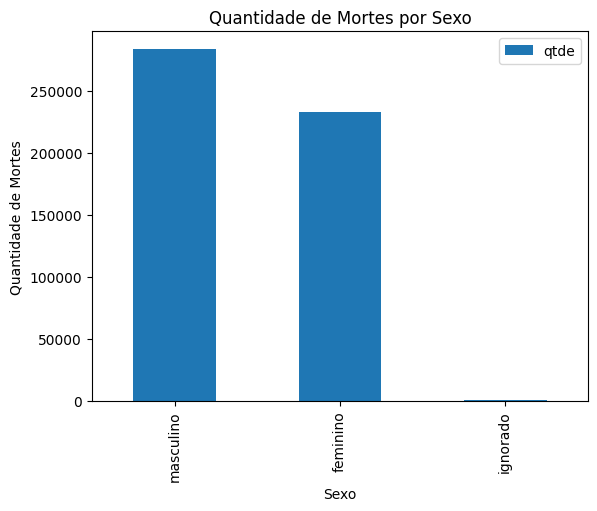

In [35]:
df_tmp.toPandas().set_index("desc_sexo").plot(kind='bar')

plt.ylabel("Quantidade de Mortes")
plt.xlabel("Sexo")
plt.title("Quantidade de Mortes por Sexo")
plt.show()

###Conclusão: a maioria das mortes é do sexo masculino.

2. Qual a distribuição de mortes por estado civil?

In [36]:
df_tmp = mort.groupBy("desc_estciv").agg(f.count("desc_estciv").alias("qtde"))
df_tmp = df_tmp.orderBy(df_tmp.qtde.desc())

df_tmp.show()

+--------------------+------+
|         desc_estciv|  qtde|
+--------------------+------+
|              Casado|154532|
|            Solteiro|132927|
|               Viúvo|119863|
|            Ignorado| 55097|
|Separado judicial...| 38097|
|       União estável| 16500|
+--------------------+------+



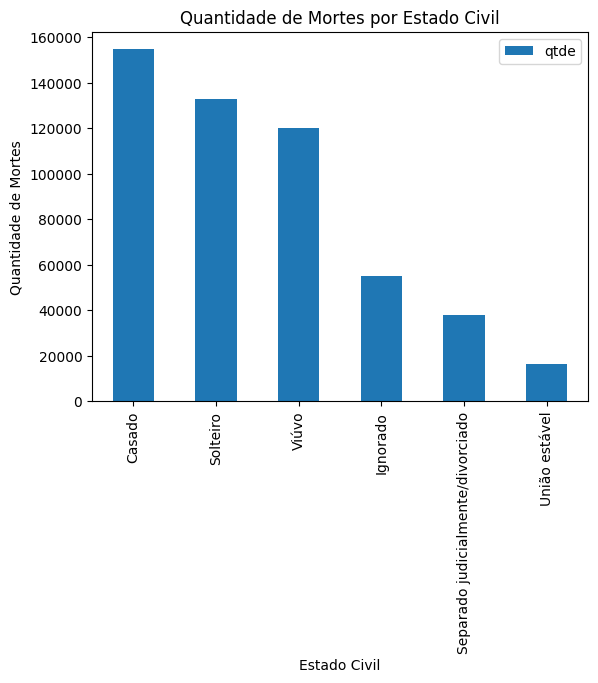

In [37]:
df_tmp.toPandas().set_index("desc_estciv").plot(kind='bar')

plt.ylabel("Quantidade de Mortes")
plt.xlabel("Estado Civil")
plt.title("Quantidade de Mortes por Estado Civil")
plt.show()

### Conclusão: a maior quantidade de mortes é de indivíduos casados, seguidos de solteiros e viúvos e etc.

3. Qual a distribuição de mortes por raça/cor?

In [38]:
df_tmp = mort.groupBy("desc_racacor").agg(f.count("desc_racacor").alias("qtde"))
df_tmp = df_tmp.orderBy(df_tmp.qtde.desc())

df_tmp.show()

+------------+------+
|desc_racacor|  qtde|
+------------+------+
|      Branca|256220|
|       Parda|193572|
|       Preta| 43181|
|    Ignorado| 19099|
|     Amarela|  3188|
|    Indígena|  1756|
+------------+------+



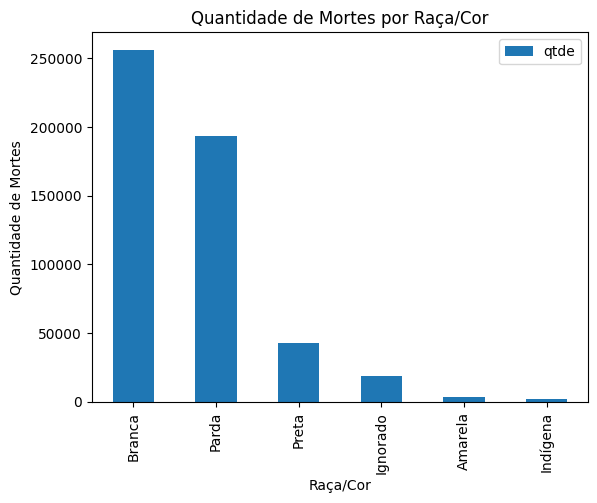

In [39]:
df_tmp.toPandas().set_index("desc_racacor").plot(kind='bar')

plt.ylabel("Quantidade de Mortes")
plt.xlabel("Raça/Cor")
plt.title("Quantidade de Mortes por Raça/Cor")
plt.show()

###Conclusão: a maior quantidade de mortes é de indivíduos brancos, e depois, pardos e pretos.

4. Qual a distribuição de mortes por escolaridade?

In [40]:
df_tmp = mort.groupBy("desc_esc2010").agg(f.count("desc_esc2010").alias("qtde"))
df_tmp = df_tmp.orderBy(df_tmp.qtde.desc())

df_tmp.show()

+-------------------+------+
|       desc_esc2010|  qtde|
+-------------------+------+
|      Fundamental I|158489|
|           Ignorado| 96124|
|     Fundamental II| 78278|
|   Sem escolaridade| 76043|
|              Médio| 75186|
|  Superior completo| 27816|
|Superior incompleto|  5080|
+-------------------+------+



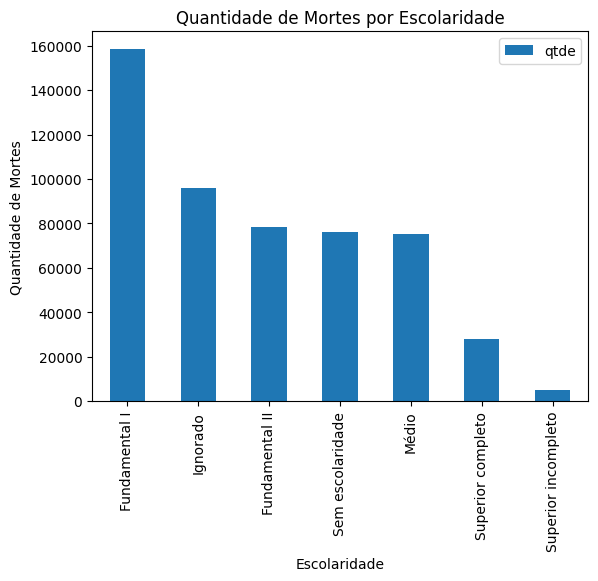

In [41]:
df_tmp.toPandas().set_index("desc_esc2010").plot(kind='bar')

plt.ylabel("Quantidade de Mortes")
plt.xlabel("Escolaridade")
plt.title("Quantidade de Mortes por Escolaridade")
plt.show()

###Conclusão: o maior número de mortes foi de pessoas com nível de escolaridade Fundamental I

5. Qual a distribuição de mortes por faixa etária?

In [42]:
df_tmp = mort.groupBy("faixa_etaria").agg(f.count("faixa_etaria").alias("qtde"))
df_tmp = df_tmp.orderBy(df_tmp.qtde.desc())

df_tmp.show()

+------------+------+
|faixa_etaria|  qtde|
+------------+------+
|     61 - 80|199725|
|    81 - 100|149115|
|     41 - 60| 92269|
|     21 - 40| 37706|
|      Até 20| 23310|
|        100+| 14891|
+------------+------+



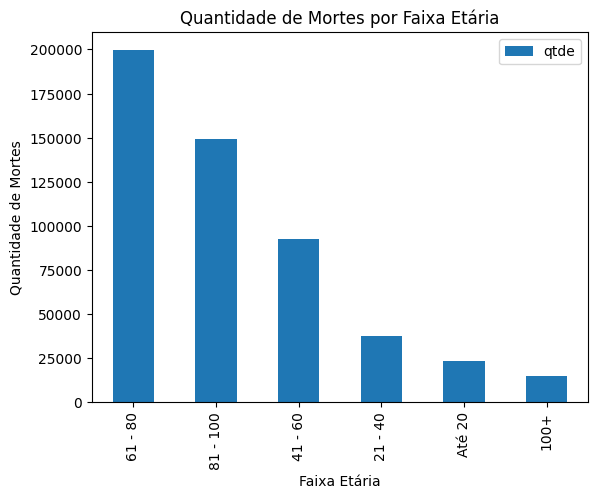

In [43]:
df_tmp.toPandas().set_index("faixa_etaria").plot(kind='bar')

plt.ylabel("Quantidade de Mortes")
plt.xlabel("Faixa Etária")
plt.title("Quantidade de Mortes por Faixa Etária")
plt.show()

###Conclusão: a faixa etária na qual ocorrem mais mortes é de 61 a 80, seguida por de 81 a 100 e de 41 a 60.

6. Qual a distribuição de mortes por circunstância de morte não natural?

In [44]:
# Morte Violenta ou Não natural (CIRCOBITO)
df_tmp = spark.sql("""select desc_circobito, count(*) as qtd_circobito
                      from v_mort
                      where CIRCOBITO <> 9
                      group by desc_circobito
                      order by qtd_circobito desc""")

df_tmp.show()

+--------------+-------------+
|desc_circobito|qtd_circobito|
+--------------+-------------+
|      acidente|        19494|
|     homicidio|        12917|
|      suicidio|         4858|
|        outros|         1480|
+--------------+-------------+



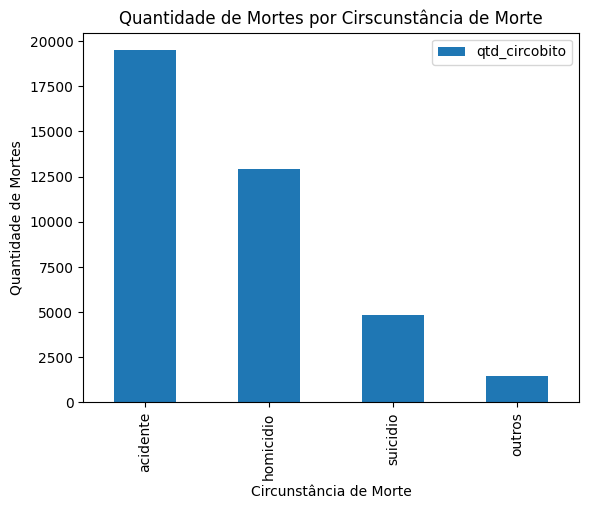

In [45]:
df_tmp.toPandas().set_index("desc_circobito").plot(kind='bar')

plt.ylabel("Quantidade de Mortes")
plt.xlabel("Circunstância de Morte")
plt.title("Quantidade de Mortes por Cirscunstância de Morte")
plt.show()

###Conclusão: A maior quantidade de mortes não naturais foi por acidente.

7. Qual a distribuição das circunstâncias de morte não natural por sexo?

In [46]:
# Morte Violenta ou Não natural (CIRCOBITO) por SEXO
df_tmp = spark.sql("""select desc_circobito, desc_sexo, count(*) as qtde
                      from v_mort
                      where CIRCOBITO <> 9
                      group by desc_circobito, desc_sexo
                      order by qtde desc""")

df_tmp.show()

+--------------+---------+-----+
|desc_circobito|desc_sexo| qtde|
+--------------+---------+-----+
|      acidente|masculino|14662|
|     homicidio|masculino|11767|
|      acidente| feminino| 4826|
|      suicidio|masculino| 3794|
|        outros|masculino| 1158|
|     homicidio| feminino| 1134|
|      suicidio| feminino| 1063|
|        outros| feminino|  319|
|     homicidio| ignorado|   16|
|      acidente| ignorado|    6|
|        outros| ignorado|    3|
|      suicidio| ignorado|    1|
+--------------+---------+-----+



###Conclusão: Os homens tem sofrido a maior quantidade de mortes não naturais com acidentes e homicídios.

8. Quais grupos de ocupação tiveram mais mortes por acidentes de trabalho?

In [47]:
# Grupos de ocupação com acidente de trabalho
df_tmp = spark.sql("""select grupo_ocup, count(*) as qtde
                      from v_mort
                      where desc_acidtrab == 'Sim'
                      group by grupo_ocup
                      order by qtde desc""")

df_tmp.show()

+--------------------+----+
|          grupo_ocup|qtde|
+--------------------+----+
|TRABALHADORES DA ...| 505|
|TRABALHADORES AGR...| 184|
|            ignorado| 170|
|TRABALHADORES DOS...| 113|
|TRABALHADORES EM ...|  91|
|TÉCNICOS DE NIVEL...|  76|
|PROFISSIONAIS DAS...|  26|
|MEMBROS SUPERIORE...|  25|
|TRABALHADORES DE ...|  22|
|MEMBROS DAS FORÇA...|   5|
+--------------------+----+



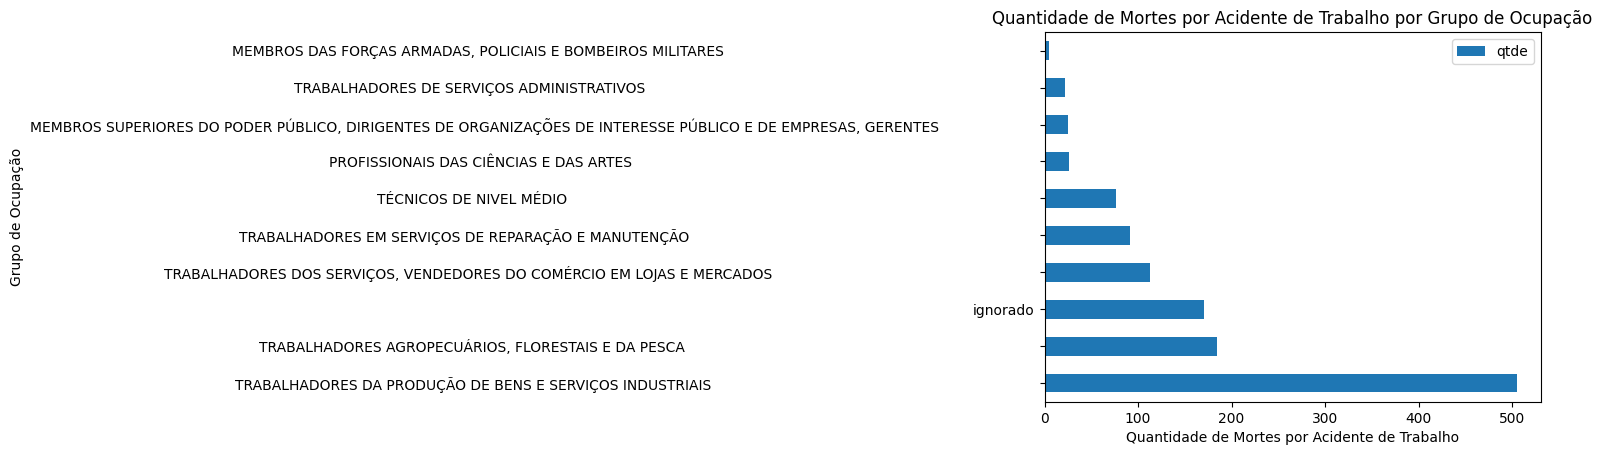

In [48]:
df_tmp.toPandas().set_index("grupo_ocup").plot(kind='barh')

plt.ylabel("Grupo de Ocupação")
plt.xlabel("Quantidade de Mortes por Acidente de Trabalho")
plt.title("Quantidade de Mortes por Acidente de Trabalho por Grupo de Ocupação")
plt.show()

###Conclusão: O grupo de trabalhadores da produção de bens e serviços industriais foi o que apresentou a maior quantidade de mortes por acidente de trabalho.

9. Qual a distribuição de mortes por causa da morte?

In [49]:
# Causa da morte
df_tmp = mort.groupBy("causa_mort").agg(f.count("causa_mort").alias("qtde"))
df_tmp = df_tmp.orderBy(df_tmp.qtde.desc())

df_tmp.show()

+--------------------+------+
|          causa_mort|  qtde|
+--------------------+------+
|IX.  Doenças do a...|129724|
|II.  Neoplasias (...| 88897|
|X.   Doenças do a...| 57043|
|XX.  Causas exter...| 50873|
|XVIII.Sint sinais...| 32540|
|I.   Algumas doen...| 28662|
|IV.  Doenças endó...| 28111|
|XI.  Doenças do a...| 26929|
|XIV. Doenças do a...| 19813|
|VI.  Doenças do s...| 17862|
|XVI. Algumas afec...| 16659|
|V.   Transtornos ...|  6216|
|XVII.Malf cong de...|  4520|
|XII. Doenças da p...|  3464|
|III. Doenças sang...|  2653|
|XIII.Doenças sist...|  2443|
|XV.  Gravidez par...|   526|
|VIII.Doenças do o...|    72|
|VII. Doenças do o...|     9|
+--------------------+------+



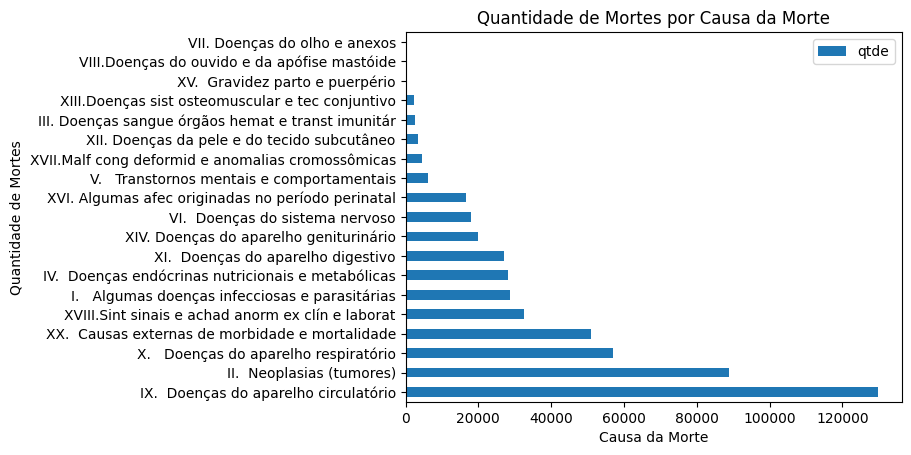

In [50]:
df_tmp.toPandas().set_index("causa_mort").plot(kind='barh')

plt.ylabel("Quantidade de Mortes")
plt.xlabel("Causa da Morte")
plt.title("Quantidade de Mortes por Causa da Morte")
plt.show()

###Conclusão: as doenças do aparelho circulatório e as neoplasias(tumores) foram as causas com mais mortes.

10. Quais as faixas etárias com maior número de suicídios?

In [51]:
df_tmp = spark.sql("""select faixa_etaria, count(*) as qtde
                      from v_mort
                      where desc_circobito == 'suicidio'
                      group by faixa_etaria
                      order by qtde desc""")

df_tmp.show()

+------------+----+
|faixa_etaria|qtde|
+------------+----+
|     21 - 40|1940|
|     41 - 60|1633|
|     61 - 80| 756|
|      Até 20| 423|
|    81 - 100| 104|
|        100+|   2|
+------------+----+



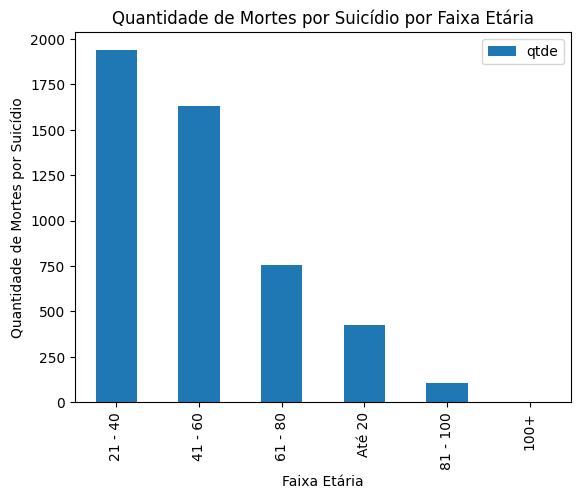

In [52]:
df_tmp.toPandas().set_index("faixa_etaria").plot(kind='bar')

plt.ylabel("Quantidade de Mortes por Suicídio")
plt.xlabel("Faixa Etária")
plt.title("Quantidade de Mortes por Suicídio por Faixa Etária")
plt.show()

###Conclusão: a faixa etária em que ocorre o maior número de suicídios é a de 21 a 40 anos.

11. Quais as causas de morte mais frequentes por UF?

In [53]:
df_tmp = spark.sql("""select Nome_UF, causa_mort, count(causa_mort) as qtde
                      from v_mort
                      group by Nome_UF, causa_mort
                      order by qtde desc""")

df_tmp.createOrReplaceTempView("v_tmp")

df_tmp2 = spark.sql("""select Nome_UF, causa_mort, qtde
                      from v_tmp v
                      where qtde = (select max(v2.qtde) from v_tmp v2 where v2.Nome_UF = v.Nome_UF)
                      order by Nome_UF""")

df_tmp2 = df_tmp2.pandas_api()
df_tmp2

,Nome_UF,causa_mort,qtde
0,Acre,IX. Doenças do aparelho circulatório,245
1,Alagoas,IX. Doenças do aparelho circulatório,2300
2,Amapá,IX. Doenças do aparelho circulatório,296
3,Amazonas,IX. Doenças do aparelho circulatório,1446
4,Bahia,IX. Doenças do aparelho circulatório,7349
5,Ceará,IX. Doenças do aparelho circulatório,5442
6,Distrito Federal,IX. Doenças do aparelho circulatório,1194
7,Espírito Santo,IX. Doenças do aparelho circulatório,2060
8,Goiás,IX. Doenças do aparelho circulatório,4086
9,Maranhão,IX. Doenças do aparelho circulatório,4220


###Conclusão: as causas de morte mais frequentes são as doenças do aparelho circulatório, independente da UF.

12. Quais as circunstâncias de morte não natural mais frequentes por UF?

In [54]:
df_tmp = spark.sql("""select Nome_UF, desc_circobito, count(desc_circobito) as qtde
                      from v_mort
                      where CIRCOBITO <> 9
                      group by Nome_UF, desc_circobito
                      order by qtde desc""")

df_tmp.createOrReplaceTempView("v_tmp")

df_tmp2 = spark.sql("""select Nome_UF, desc_circobito, qtde
                      from v_tmp v
                      where qtde = (select max(v2.qtde) from v_tmp v2 where v2.Nome_UF = v.Nome_UF)
                      order by Nome_UF""")

df_tmp2 = df_tmp2.pandas_api()
df_tmp2

,Nome_UF,desc_circobito,qtde
0,Acre,homicidio,78
1,Alagoas,acidente,382
2,Amapá,homicidio,137
3,Amazonas,homicidio,458
4,Bahia,homicidio,1704
5,Ceará,acidente,864
6,Distrito Federal,acidente,101
7,Espírito Santo,acidente,370
8,Goiás,acidente,851
9,Maranhão,acidente,748


###Conclusão: as mortes por acidente são as mais frequentes na maior parte das UF's.